In [252]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import plotly.express as px
from pathlib import Path
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter('always', category=UserWarning)
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.compose import TransformedTargetRegressor, make_column_transformer, ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline

### But du projet

Construire un modèle de machine learning capable d'estimer les ventes hebdomadaires dans leurs magasins, avec la meilleure précision possible sur les prédictions faites

### Objectifs

- Partie 1 : réaliser un EDA et tous les prétraitements nécessaires pour préparer les données pour le machine learning
- Partie 2 : former un modèle de **régression linéaire** (baseline)
- Partie 3 : éviter le surajustement en entraînant un modèle de **régression régularisé**

### Features

**`Store`** - Numéro du magasin</br>
**`Date`**  - Semaine des ventes</br>
**`Weekly_Sales`**  - Ventes pour le magasin donné</br>
**`Holiday_Flag`**  - Si la semaine est spéciale(jour férié) :  week 1 – semaine spécial / week 0 – semaine de non-spécial</br>
**`Temperature`**  - Température le jour de la vente</br>
**`Fuel_Price`**  - Coût de carburant dans la région</br>
**`CPI`**  – Indice des prix à la consommation</br>
**`Unemployment`**  - Taux de chômage</br>

**Jours fériés** : </br>
**Super Bowl**: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13</br>
**Labour Day**: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13</br>
**Thanksgiving**: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13</br>
**Christmas**: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

# Partie 1 : EDA

In [40]:
f = r'C:\Users\david\JEDHA BOOTCAMP\FULLSTACK\10_PROJECT\Walmart'
data_dir = Path(f)
paths = list((data_dir).glob('*.csv'))

In [41]:
paths

[WindowsPath('C:/Users/david/JEDHA BOOTCAMP/FULLSTACK/10_PROJECT/Walmart/conversion_data_test.csv'),
 WindowsPath('C:/Users/david/JEDHA BOOTCAMP/FULLSTACK/10_PROJECT/Walmart/conversion_data_train.csv'),
 WindowsPath('C:/Users/david/JEDHA BOOTCAMP/FULLSTACK/10_PROJECT/Walmart/Walmart_Store_sales.csv')]

In [42]:
walmart_sales = pd.read_csv('./src/Walmart_Store_sales.csv')

In [43]:
walmart_sales.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092


In [44]:
walmart_sales.shape

(150, 8)

Il y a très peu de lignes : ce dataset regroupe les ventes hebdomadaires des magasins Walmart

In [45]:
walmart_sales.isna().sum() / walmart_sales.shape[0]

Store           0.000000
Date            0.120000
Weekly_Sales    0.093333
Holiday_Flag    0.080000
Temperature     0.120000
Fuel_Price      0.093333
CPI             0.080000
Unemployment    0.100000
dtype: float64

<AxesSubplot:>

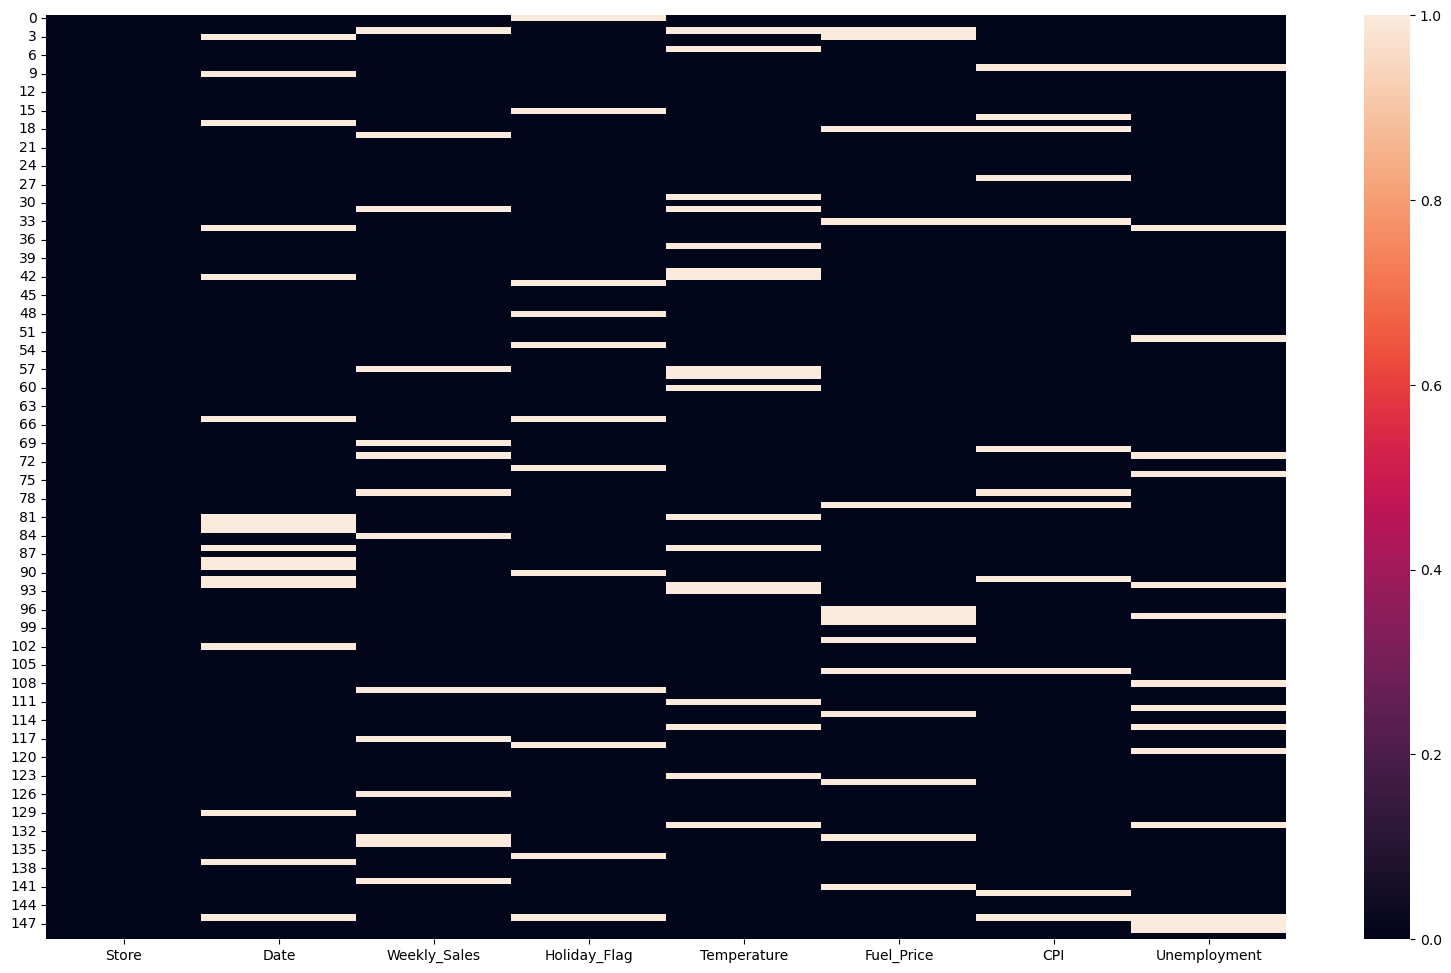

In [46]:
plt.figure(figsize=(20,12))
sns.heatmap(walmart_sales.isna())

les données manquantes sont assez dispersées dans le dataset

In [47]:
df = walmart_sales.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         150 non-null    float64
 1   Date          132 non-null    object 
 2   Weekly_Sales  136 non-null    float64
 3   Holiday_Flag  138 non-null    float64
 4   Temperature   132 non-null    float64
 5   Fuel_Price    136 non-null    float64
 6   CPI           138 non-null    float64
 7   Unemployment  135 non-null    float64
dtypes: float64(7), object(1)
memory usage: 9.5+ KB


Il n'y a que des valeurs numériques sauf la colonne **`Date`**

## Observation sommaire du dataset

In [48]:
df.describe(include='all')

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,19-10-2012,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000


<Figure size 432x288 with 0 Axes>

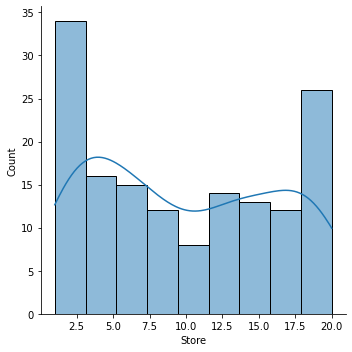

<Figure size 432x288 with 0 Axes>

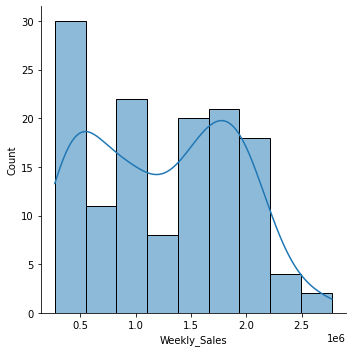

<Figure size 432x288 with 0 Axes>

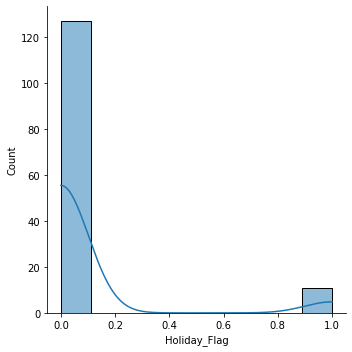

<Figure size 432x288 with 0 Axes>

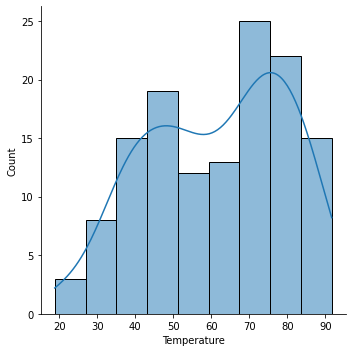

<Figure size 432x288 with 0 Axes>

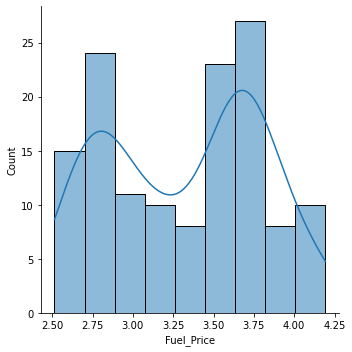

<Figure size 432x288 with 0 Axes>

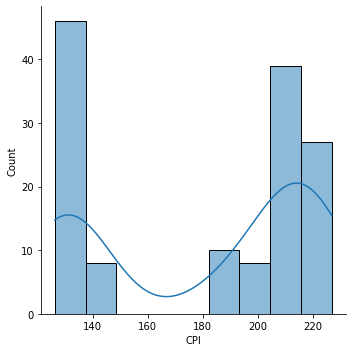

<Figure size 432x288 with 0 Axes>

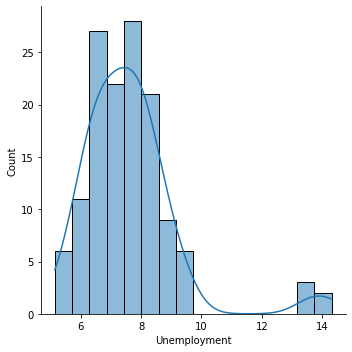

In [32]:
for col in df.columns:
    if col != 'Date':
        plt.figure()
        sns.displot(df[col], kde=True);

**`Weekly_Sales`** : Le montant des ventes est assez homogène : Il y a plus de petites ventes que de grosses mais la distribution reste uniforme avec quelques variations
    
**`Holiday_Flag`** : on observe une très grande majorité de semaine de non-vacances 

**`Temperature`** : la plage de temperature est assez uniforme avec un peu plus de temperature élevée que très basse

**`Fuel_Price`** : De même, nous observons une homogénité dans les données avec quelques pics à 2.85 et 3.65

**`CPI`** : Indice des prix à la consommation est soit très faible, soit très élevé : 


In [49]:
df['Weekly_Sales'].isna().sum()

14

Il y a 14 lignes qui comportent des valeurs manquantes pour la colonne **`Weekly_Sales`** : nous allons supprimer ces lignes

In [50]:
df[df['Weekly_Sales'].isna()]

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
19,3.0,18-05-2012,NaN,0.0,72.38,3.630,225.251202,6.664
31,5.0,30-12-2011,NaN,1.0,NaN,3.129,220.117823,6.300
57,4.0,07-01-2011,NaN,0.0,NaN,2.980,127.191774,6.510
69,20.0,26-03-2010,NaN,0.0,50.49,2.854,204.201755,8.187
71,20.0,07-09-2012,NaN,1.0,76.36,3.911,215.218957,NaN
77,3.0,29-07-2011,NaN,0.0,88.07,3.682,NaN,7.567
84,8.0,03-09-2010,NaN,0.0,76.14,2.577,214.894576,6.315
109,1.0,09-12-2011,NaN,NaN,43.93,3.158,218.961846,7.866
117,19.0,13-04-2012,NaN,0.0,44.42,4.187,137.868000,8.150


In [51]:
df = df[~df['Weekly_Sales'].isna()]

## Feature Engineering

Nous allons transformer la colonne **`Date`** en datetime puis créer des sous-catégories de date : **`year`**, **`month`**, **`day`**, **`weekday`** : avant de le faire, nous devons prendre une décision pour les dates manquantes : soit nous faisons une interpolation, soit nous les supprimons (sachant qu'il y a 12% de valeurs manquantes avec peu de lignes dans le dataframe)

Si nous faisons une interpolation, nous allons fausser des résultats car une date peut influencer le montant des ventes (nous le verrons plus tard avec la matrice de corrélation)

Je décide donc, pour l'instant, de supprimer les valeurs manquantes de la colonne **`Date`**

In [52]:
df = df[~df['Date'].isnull()]

In [53]:
df.Date = pd.to_datetime(df.Date, infer_datetime_format=True)

df['year'] = df.Date.dt.year
df['month'] = df.Date.dt.month
df['day'] = df.Date.dt.day
df['weekday'] = df.Date.dt.weekday

In [54]:
df

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,day,weekday
0,6.0,2011-02-18,1572117.54,NaN,59.61,3.045,214.777523,6.858,2011,2,18,4
1,13.0,2011-03-25,1807545.43,0.0,42.38,3.435,128.616064,7.470,2011,3,25,4
4,6.0,2010-05-28,1644470.66,0.0,78.89,2.759,212.412888,7.092,2010,5,28,4
5,4.0,2010-05-28,1857533.70,0.0,NaN,2.756,126.160226,7.896,2010,5,28,4
6,15.0,2011-06-03,695396.19,0.0,69.80,4.069,134.855161,7.658,2011,6,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...
144,3.0,2012-10-19,424513.08,0.0,73.44,3.594,226.968844,6.034,2012,10,19,4
145,14.0,2010-06-18,2248645.59,0.0,72.62,2.780,182.442420,8.899,2010,6,18,4
147,17.0,2010-06-11,845252.21,0.0,57.14,2.841,126.111903,NaN,2010,6,11,4
148,8.0,2011-08-12,856796.10,0.0,86.05,3.638,219.007525,NaN,2011,8,12,4


In [55]:
df[df['Holiday_Flag'] == 1]

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,day,weekday
32,7.0,2012-02-10,563460.77,1.0,18.79,3.103,196.919506,8.256,2012,2,10,4
33,14.0,2012-02-10,2077256.24,1.0,37.00,NaN,NaN,8.424,2012,2,10,4
44,1.0,2010-02-12,1641957.44,1.0,38.51,2.548,211.242170,8.106,2010,2,12,4
107,8.0,2010-02-12,994801.40,1.0,33.34,2.548,214.621419,6.299,2010,2,12,4
110,20.0,2010-12-31,1799737.79,1.0,28.85,3.179,204.643227,7.484,2010,12,31,4
114,11.0,2010-11-26,1757242.51,1.0,69.90,2.735,215.061403,7.564,2010,11,26,4
122,7.0,2012-09-07,597876.55,1.0,57.84,3.596,198.095048,7.872,2012,9,7,4
135,12.0,2010-09-10,903119.03,1.0,83.63,3.044,126.114581,14.180,2010,9,10,4


In [56]:
df['weekday'].unique()

array([4], dtype=int64)

Toutes les lignes représentent un jeudi

In [57]:
df[df.Temperature.isna()]

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,day,weekday
5,4.0,2010-05-28,1857533.70,0.0,NaN,2.756,126.160226,7.896,2010,5,28,4
29,6.0,2011-08-26,1420405.41,0.0,NaN,3.523,217.270654,6.925,2011,8,26,4
37,18.0,2011-04-15,988157.72,0.0,NaN,3.823,134.278467,8.975,2011,4,15,4
41,16.0,2012-09-14,526525.16,0.0,NaN,3.659,198.126718,6.061,2012,9,14,4
58,6.0,2010-07-30,1532308.78,0.0,NaN,2.640,212.894485,6.973,2010,7,30,4
60,14.0,2011-05-06,2095599.93,0.0,NaN,4.046,185.937438,8.521,2011,5,6,4
93,12.0,2011-05-27,964332.51,0.0,NaN,4.087,129.062355,13.736,2011,5,27,4
111,19.0,2012-06-22,1468350.36,0.0,NaN,3.722,138.162900,8.150,2012,6,22,4
115,15.0,2010-02-19,660838.75,0.0,NaN,2.909,131.637000,NaN,2010,2,19,4
123,1.0,2011-05-27,1466046.67,0.0,NaN,3.786,215.503788,7.682,2011,5,27,4


In [58]:
df.dtypes

Store                  float64
Date            datetime64[ns]
Weekly_Sales           float64
Holiday_Flag           float64
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
year                     int64
month                    int64
day                      int64
weekday                  int64
dtype: object

In [59]:
df2 = df.copy()

In [60]:
def replace_outliers(df,n=3):
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        mean = df[col].mean()
        std = df[col].std()
        outliers = (df[col] - mean).abs() > std*n
        df = df[~outliers]
    return df

En supprimant les outliers, cad les valeurs qui s'éloignent de plus de 3 ecarts-types de la moyennes, nous n'auront plus de jours fériés dans le dataset (avant suppression, il en restant 8)

In [61]:
df_without_outliers = replace_outliers(df2).reset_index().drop(['index'],axis=1)
df_without_outliers

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,day,weekday
0,6.0,2011-02-18,1572117.54,NaN,59.61,3.045,214.777523,6.858,2011,2,18,4
1,13.0,2011-03-25,1807545.43,0.0,42.38,3.435,128.616064,7.470,2011,3,25,4
2,6.0,2010-05-28,1644470.66,0.0,78.89,2.759,212.412888,7.092,2010,5,28,4
3,4.0,2010-05-28,1857533.70,0.0,NaN,2.756,126.160226,7.896,2010,5,28,4
4,15.0,2011-06-03,695396.19,0.0,69.80,4.069,134.855161,7.658,2011,6,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...
101,3.0,2012-10-19,424513.08,0.0,73.44,3.594,226.968844,6.034,2012,10,19,4
102,14.0,2010-06-18,2248645.59,0.0,72.62,2.780,182.442420,8.899,2010,6,18,4
103,17.0,2010-06-11,845252.21,0.0,57.14,2.841,126.111903,NaN,2010,6,11,4
104,8.0,2011-08-12,856796.10,0.0,86.05,3.638,219.007525,NaN,2011,8,12,4


In [62]:
target = df_without_outliers['Weekly_Sales']
df_without_outliers.drop(['Date'], axis=1, inplace=True)

In [63]:
df_without_outliers.isna().sum()

Store            0
Weekly_Sales     0
Holiday_Flag     9
Temperature     10
Fuel_Price      10
CPI              8
Unemployment    11
year             0
month            0
day              0
weekday          0
dtype: int64

### Valeurs manquantes

Variables numériques : **`Température`**, **`Fuel_Price`**, **`CPI`**, **`Unemployment`**</br>
Variable catégorielle : **`Holiday_Flag`**

Il faut trouver une strategie de remplacement de valeurs manquantes pour ces colonnes :

- **`Holiday_Flag`** : il suffit de determiner avec la date si c'est un jour férié ou non
- **`Temperature`** : nous pouvons remplacer les NaN par la moyenne en fonction du mois de l'année
- **`Fuel_Price`** : on distingue que le prix de l'essence depend de l'année donc on va remplacer les NaN par la moyenne de chaque année 
- **`CPI`** : il augmente legerement en fonction de l'année mais n'est corrélé a rien, ce qui pose problème : on va utiliser KNNImputer pour remplacer les valeurs manquantes car il y a 2 distributions très différentes
- **`Unemployment`** : en supprimant les outliers, nous avons qu'une seule distributions donc nous pouvons prendre la moyenne de celle-ci

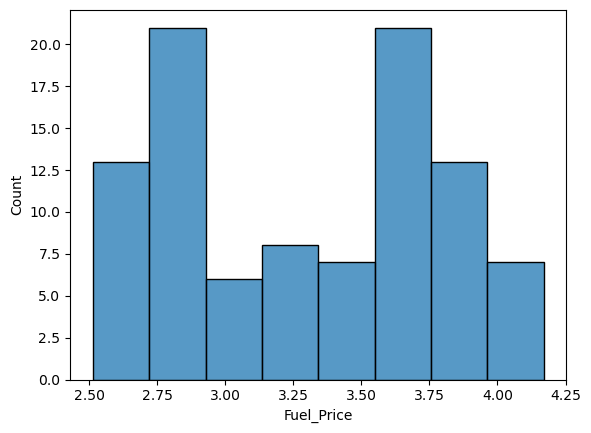

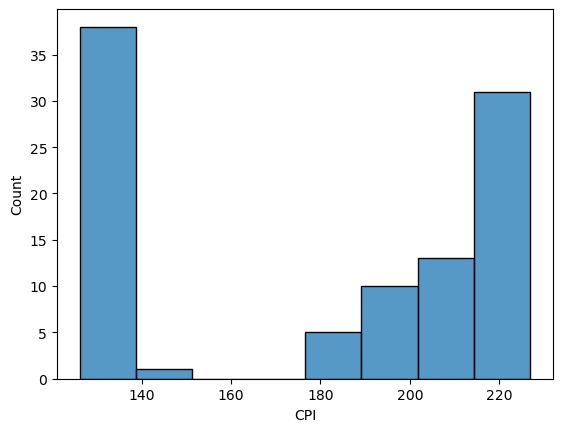

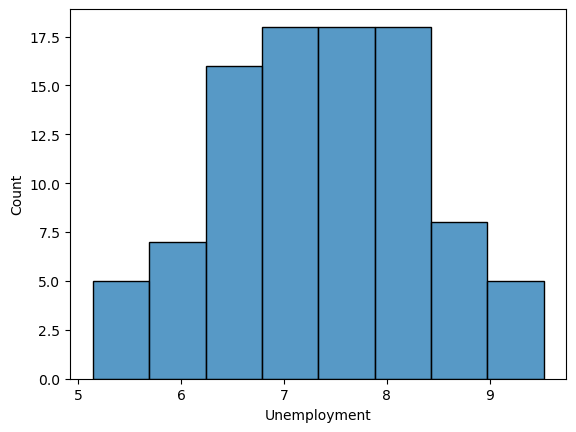

In [68]:
for col in ['Fuel_Price', 'CPI', 'Unemployment']:
    plt.figure()
    sns.histplot(df_without_outliers[col], bins=8);

year
2010    2.782026
2011    3.567125
2012    3.743120
Name: Fuel_Price, dtype: float64

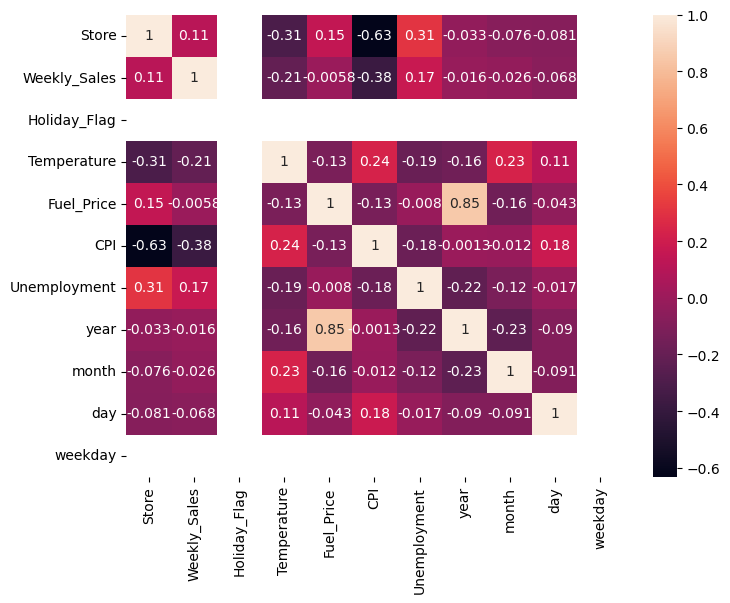

In [65]:
display(df_without_outliers.groupby('year')['Fuel_Price'].mean())
plt.figure(figsize=(8,6))
sns.heatmap(df_without_outliers.corr(),annot=True);

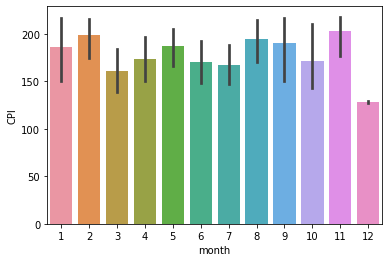

In [50]:
sns.barplot(data=df_without_outliers, x='month', y='CPI');

In [69]:
# remplacement des NaN de 'Holiday_Flag'
df_without_outliers['Holiday_Flag'].fillna(0.0, inplace=True)

# remplacement des NaN de 'Temperature'
gb_month = df_without_outliers.groupby('month')
df_without_outliers['Temperature'] = round(df_without_outliers['Temperature'].fillna(gb_month['Temperature'].transform('mean')),2)

# remplacement des NaN de 'Fuel_Price'
gb_month = df_without_outliers.groupby('year')
df_without_outliers['Fuel_Price'] = round(df_without_outliers['Fuel_Price'].fillna(gb_month['Fuel_Price'].transform('mean')),3)

# remplacement des NaN de 'Unemployment'
df_without_outliers['Unemployment'] = df_without_outliers['Unemployment'].fillna(df_without_outliers['Unemployment'].mean())

In [70]:
df_without_outliers.isna().sum()

Store           0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             8
Unemployment    0
year            0
month           0
day             0
weekday         0
dtype: int64

In [71]:
df_without_outliers = df_without_outliers[df_without_outliers['CPI'].notna()]
df_without_outliers.isna().sum()

Store           0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
year            0
month           0
day             0
weekday         0
dtype: int64

## Preprocessing

In [166]:
X = df_without_outliers.drop(['Weekly_Sales'], axis=1)
y = df_without_outliers['Weekly_Sales']

In [167]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [172]:
X_train['Store'].sort_values().unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 13., 14., 15.,
       16., 17., 18., 19., 20.])

In [155]:
X_train.columns

Index(['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment', 'year', 'month', 'day', 'weekday'],
      dtype='object')

In [156]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((78, 10), (20, 10), (78,), (20,))

In [157]:
X_train.isna().sum().sum()

0

In [158]:
X_train.columns, X_test.columns

(Index(['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI',
        'Unemployment', 'year', 'month', 'day', 'weekday'],
       dtype='object'),
 Index(['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI',
        'Unemployment', 'year', 'month', 'day', 'weekday'],
       dtype='object'))

### Modèles

On va d'abord tester un modèle `baseline` pour voir le score

In [159]:
len(df['Store'].unique())

20

On definit la colonne `Store` comme feature catégorielle : en ayant supprimer les outliers et les NaN (nous n'allons pas faire d'extrapolation sur le Store car chaque magasin à un numéro unique ) cad que sur 20 magasins, il en reste 18(il manque 11 et 12) qui vont avoir leur propres colonnes onehot encoded, cad 18 colonnes (sans le drop='first') donc il n'en restera que 17

In [160]:
categorical_features = X_train[['Store']].columns
X_train = X_train[['Store']]
X_test = X_test[['Store']]
X_train.shape, X_test.shape

((78, 1), (20, 1))

In [162]:
onehot = OneHotEncoder(drop='first')
X_train = onehot.fit_transform(X_train)
X_test = onehot.transform(X_test)

In [163]:
X_train.shape

(78, 17)

In [164]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [165]:
print(lr.score(X_train, y_train))
print(lr.score(X_test, y_test))

0.9615849236587543
0.9798033134494765


On obtient de très bon score avec seulement le numéro du magasin. On va tester avec toutes les colonnes disponibles

2 variables categorielles : **`Store`** et **`Holiday_Flag`**

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [174]:
numerical_features = X_train[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'year', 'month', 'day','weekday']].columns
categorical_features = X_train[['Store','Holiday_Flag']].columns

In [175]:
numerical_features

Index(['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'year', 'month',
       'day', 'weekday'],
      dtype='object')

In [176]:
categorical_features

Index(['Store', 'Holiday_Flag'], dtype='object')

In [177]:
X_train.shape, X_test.shape

((78, 10), (20, 10))

### Testons le modele

D'après les distributions obtenues avec **`sns.displot`**, elles ne semblent pas être normales donc appliquons un MinMaxScaler qui conserve la forme des distributions.

Comme nous avons supprimer les outliers, pas besoin d'utiliser un RobustScaler.

In [178]:
df_without_outliers.columns

Index(['Store', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price',
       'CPI', 'Unemployment', 'year', 'month', 'day', 'weekday'],
      dtype='object')

In [175]:
from numpy import s_

arr = df_without_outliers.columns.tolist()
slices = s_[0,2:]

def xslice(arr, slices):
    if isinstance(slices, tuple):
        return sum((arr[s] if isinstance(s, slice) else [arr[s]] for s in slices), [])
    elif isinstance(slices, slice):
        return arr[slices]
    else:
        return [arr[slices]]
    
select_features = xslice(arr, slices)
select_features

['Store',
 'Holiday_Flag',
 'Temperature',
 'Fuel_Price',
 'CPI',
 'Unemployment',
 'year',
 'month',
 'day',
 'weekday']

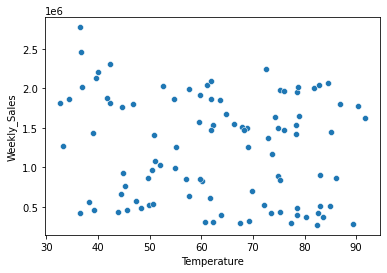

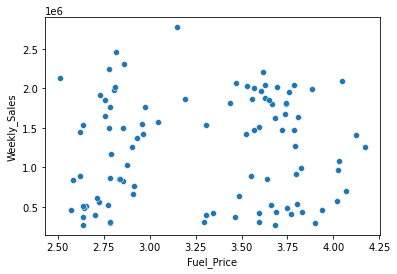

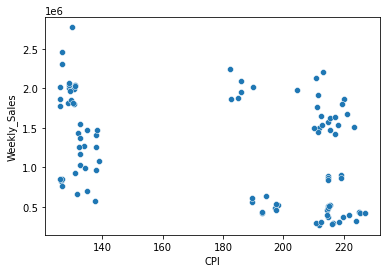

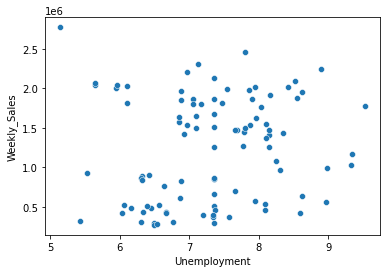

In [176]:
for col in select_features:
    if col not in X_train[['Store','Holiday_Flag', 'year', 'month', 'day','weekday']].columns:
        plt.figure()
        sns.scatterplot(x=df_without_outliers[col], y=target);

In [179]:
# modl = TransformedTargetRegressor(regressor=LinearRegression(), transformer=MinMaxScaler())
pip1 = Pipeline([('MinMaxScaler', MinMaxScaler()),
                 ('KNNImputer', KNNImputer(n_neighbors=3)),
                 ('OneHotEncoder', OneHotEncoder()),
                 ('Regressor', LinearRegression())])

preprocessor = make_column_transformer(
    (pip1[0:2], numerical_features),
    (pip1[2], categorical_features))

preprocessor

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('MinMaxScaler',
                                                  MinMaxScaler()),
                                                 ('KNNImputer',
                                                  KNNImputer(n_neighbors=3))]),
                                 Index(['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'year', 'month',
       'day', 'weekday'],
      dtype='object')),
                                ('onehotencoder', OneHotEncoder(),
                                 Index(['Store', 'Holiday_Flag'], dtype='object'))])

In [180]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [181]:
pip1[3].fit(X_train,y_train)

print(pip1[3].score(X_train, y_train))
print(pip1[3].score(X_test, y_test))

0.9764459429384228
0.9616484150193494


Il y a un peu d'overfitting (c'est très léger), on va faire un cross_val_score pour le confirmer

In [182]:
score_model1 = cross_val_score(pip1[3], X_train, y_train, cv = 10)

print("Tous les scores : ", score_model1)
print('Le cross-validated R2-score est : ', score_model1.mean())
print("L'ecart-type est de : ", score_model1.std())

Tous les scores :  [0.95384827 0.90655919 0.95702669 0.95053239 0.91646667 0.97151405
 0.92756379 0.90443469 0.95886138 0.92569154]
Le cross-validated R2-score est :  0.9372498664043658
L'ecart-type est de :  0.02272059991031116


On voit que les scores sont assez aléatoires allant de 0.97 à 0.66 : cela est du au faible nombre de samples dans le dataset.
la moyenne est de 0.84 avec un ecart type de 0.1 : il y a peu d'overfitting.

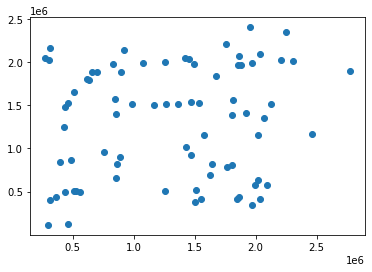

In [155]:
plt.scatter(y_train.sort_values(), pip1[3].predict(X_train))

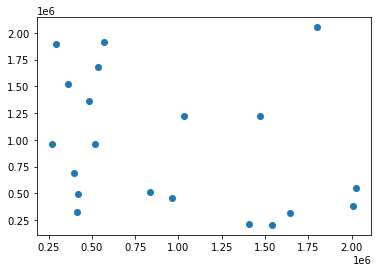

In [156]:
plt.scatter(y_test.sort_values(), pip1[3].predict(X_test))

In [124]:
pip1[3].coef_

array([-1.72342502e+05, -2.28784140e+04,  2.43806708e+06, -3.05986606e+05,
       -2.92155341e+05,  1.76177535e+05, -1.39907676e+05, -8.14907253e-10,
       -5.26541989e+05, -1.67906491e+05, -1.83070221e+06,  2.03867985e+06,
       -1.91700763e+06, -5.54492899e+05, -9.87507888e+05, -1.36359648e+06,
       -1.72545339e+06,  1.97271955e+06,  1.92175318e+06,  7.14030270e+05,
        4.95624031e+05, -1.14296380e+06,  6.47977837e+05,  1.00199807e+06,
        1.26568045e+06,  1.57709551e+05,  0.00000000e+00])

In [191]:
stores = [f'Store_{i}' for i in range(1,21)]
exclude_stores = ['Store_11', 'Store_12']
stores_non_exclude = [store for store in stores if store not in exclude_stores]
stores_non_exclude

['Store_1',
 'Store_2',
 'Store_3',
 'Store_4',
 'Store_5',
 'Store_6',
 'Store_7',
 'Store_8',
 'Store_9',
 'Store_10',
 'Store_13',
 'Store_14',
 'Store_15',
 'Store_16',
 'Store_17',
 'Store_18',
 'Store_19',
 'Store_20']

In [192]:
for el,col in zip(pip1[3].coef_[:18], stores_non_exclude[1:]):
    print(f"{col : <12} : {round(el,2)}") 

Store_2      : -172342.5
Store_3      : -22878.41
Store_4      : 2438067.08
Store_5      : -305986.61
Store_6      : -292155.34
Store_7      : 176177.53
Store_8      : -139907.68
Store_9      : -0.0
Store_10     : -526541.99
Store_13     : -167906.49
Store_14     : -1830702.21
Store_15     : 2038679.85
Store_16     : -1917007.63
Store_17     : -554492.9
Store_18     : -987507.89
Store_19     : -1363596.48
Store_20     : -1725453.39


On observe quelque **`'Store'`** comme le numéro $4$, le $7$ et le $15$ qui ont une corrélation positive avec **`'Weekly sales'`**, les autres ont une corrélation négative

In [193]:
for el,col in zip(pip1[3].coef_[18:], X.columns.values[1:]):
    print(f"{col : <12} : {round(el,2)}")

Holiday_Flag : 1921753.18
Temperature  : 714030.27
Fuel_Price   : 495624.03
CPI          : -1142963.8
Unemployment : 647977.84
year         : 1001998.07
month        : 1265680.45
day          : 157709.55
weekday      : 0.0


Un coefficient négatif suggère que lorsque la variable indépendante(**feature Xi**) augmente, la variable dépendante (**target**) tend à diminuer. La valeur du coefficient indique de combien la moyenne de la variable dépendante change compte tenu d'un décalage d'une unité dans la variable indépendante tout en maintenant les autres variables dans le modèle constant.

On peut donc dire que lorsque **`'CPI'`** augmente (en ne prenant pas en compte **`'day'`**), qui a le coefficient le plus élevé négativement, **`'Weekly sales'`** baisse.</br>
Alors que, si **`'Temperature'`** ou  **`'Holiday_Flag '`** augmente, qui a le coefficient le plus élevé positivement, alors **`'Weekly sales'`** augmente

### Esssayons Ridge quand même pour voir si ça améliore le score

In [159]:
regressor = Ridge()

params = {
    'alpha': np.arange(0,50,2)
}

gridsearch = GridSearchCV(regressor, param_grid = params, cv = 10)
gridsearch.fit(X_train, y_train)

print("Meilleurs hyperparametres : ", gridsearch.best_params_)
print("Meilleur R2-score : ", gridsearch.best_score_)

Meilleurs hyperparametres :  {'alpha': 0}
Meilleur R2-score :  0.9372141340069495


In [160]:
print("R2-score sur le training set : ", gridsearch.score(X_train, y_train))
print("R2-score sur le test set : ", gridsearch.score(X_test, y_test))

R2-score sur le training set :  0.9764459429384228
R2-score sur le test set :  0.9616484150193487


Il n'y a aucun changement avec Ridge

In [161]:
scores = cross_val_score(gridsearch.best_estimator_, X_train, y_train, cv = 10)

print('Le cross-validated R2-score est : ', scores.mean())
print("L'ecart-type est de : ", scores.std())

Le cross-validated R2-score est :  0.9372141340069495
L'ecart-type est de :  0.022739022958880323


### Essayons avec Lasso

In [ ]:
regressor = Lasso()

lasso_params = {'alpha':[0.002, 0.0024, 0.0025, 0.0026, 0.003]}

gridsearch = GridSearchCV(regressor, param_grid = lasso_params, cv = 8)
gridsearch.fit(X_train, y_train)

print("Meilleurs hyperparametres : ", gridsearch.best_params_)
print("Meilleur R2-score : ", gridsearch.best_score_)

Meilleurs hyperparametres :  {'alpha': 0.02}</br>
Meilleur R2-score :  0.9356659780278879

Le score n'est guère mieux : retirons des features pour observer si on peut améliorer le score. On va donc analyser les coefficients de Lasso pour repérer quelle feature crée de l'overfitting

In [96]:
gridsearch.best_estimator_.coef_

array([ -168158.08891101,   -51214.7118945 ,   931593.27505998,
        -278421.09969063,  -148824.42876733,   218958.90124075,
        -125109.45639178,        0.        ,  -184566.91638305,
         155804.0519886 , -1425939.91956382,  1092630.23997196,
       -1562469.81236064,  -203204.46850904,  -977157.69928141,
        -973773.66099195, -1339303.21635592,   995920.95987548,
         964987.34504852,   604292.46581516,  -349374.2613579 ,
       -1132149.34331449,  -297041.33772964,   137125.54732352,
         406945.12898757,   399693.15350413,        0.        ])

In [97]:
preprocessor.feature_names_in_

array(['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment', 'year', 'month', 'day', 'weekday'], dtype=object)

In [98]:
preprocessor.output_indices_

{'pipeline': slice(0, 8, None),
 'onehotencoder': slice(8, 27, None),
 'remainder': slice(0, 0, None)}

On va associer les features aux coefficients : il va falloir faire attention à l'ordre des features car il y en a des catégorielles et des numériques. 

In [201]:
features_list = [stores_non_exclude + preprocessor.feature_names_in_[1:].tolist()]
print(len(features_list[0]))

27


In [207]:
podium_coef = pd.DataFrame()

In [220]:
coef_df = pd.DataFrame(gridsearch.best_estimator_.coef_, index=features_list, columns=['coef_'])
coef_df['coef_']=round(coef_df['coef_'],2)
coef_df = coef_df.reset_index().rename(columns={'level_0':'features_name'})

In [223]:
fig = px.bar(coef_df, x='coef_', y='features_name', title='Valeur des coefficients par features')
fig.show()

On observe bien que les variables les plus importantes sont les `Stores` : On voit aussi que certaines features sont bien neutralisée par Lasso (comme year)

Testons de retirer les features que Lasso neutralise (comme year, month, day, weekday) et observons le resultat

In [224]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [225]:
numerical_features = X_train[['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']].columns
categorical_features = X_train[['Store','Holiday_Flag']].columns

In [230]:
preprocessor = make_column_transformer(
    (pip1[0:2], numerical_features),
    (pip1[2], categorical_features))

preprocessor

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('MinMaxScaler',
                                                  MinMaxScaler()),
                                                 ('KNNImputer',
                                                  KNNImputer(n_neighbors=3))]),
                                 Index(['Temperature', 'Fuel_Price', 'CPI', 'Unemployment'], dtype='object')),
                                ('onehotencoder', OneHotEncoder(),
                                 Index(['Store', 'Holiday_Flag'], dtype='object'))])

In [231]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [247]:
regressor = Lasso()

params={
    'alpha':[400, 500, 600, 700, 735, 740, 745, 800]
}

gridsearch = GridSearchCV(regressor, param_grid = params, cv = 8)
gridsearch.fit(X_train, y_train)

print("Meilleurs hyperparametres : ", gridsearch.best_params_)
print("Meilleur R2-score : ", gridsearch.best_score_)

Meilleurs hyperparametres :  {'alpha': 600}
Meilleur R2-score :  0.922654367661922


In [256]:
import sys

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

In [257]:
regressor.fit(X_train, y_train)

y_pred_train = regressor.predict(X_train)
y_pred_test = regressor.predict(X_test)

print (f'R2-score sur le Train: {r2_score(y_train, y_pred_train)}')
print (f'R2-score sur le Test : {r2_score(y_test, y_pred_test)}')
print (f'Cross_Val_Score MEAN sur le Train : {cross_val_score(regressor, X_train, y_train, cv=10).mean()}')
print (f'Cross_Val_Score Std sur le Test : {cross_val_score(regressor, X_train, y_train, cv=10).std()}')

R2-score sur le Train: 0.9667489752285308
R2-score sur le Test : 0.982287914866134
Cross_Val_Score MEAN sur le Train : 0.9208236343388416
Cross_Val_Score Std sur le Test : 0.039063889366023084


On a réussi à faire baisser l'overfitting (en baissant légérement l'accuracy de notre modèle)

### Feature Engineering 

Le feature engineering va faire augmenter l'overfitting mais améliore t'il le modèle sur le train ? Testons pour voir !

In [183]:
poly = PolynomialFeatures(2)
X_train = poly.fit_transform(X_train)
X_test = poly.transform(X_test)

In [184]:
pip1[3].fit(X_train,y_train)

print(pip1[3].score(X_train, y_train))
print(pip1[3].score(X_test, y_test))

1.0
0.8876888170182896


On créant de nouvelles variables, on overfit de plus en plus sans vraiment améliorer le modèle du train et en baissant le score sur le test, donc ce n'est pas une bonne idée

### Time Series

Nous allons utiliser des modèles de série temporelle pour essayer de prédire les ventes des magasins. On va découper notre dataset en 2 périodes : une qui sera le train (le passé) et une qui sera le test (le futur).

Cependant, il nous manque certaines données pour réussir à faire du Time Series : Nous n'avons pas tous les C.A par magasin, ce qui va nous poser un problème de biais pour les magasins les plus représentés. Testons voir les resultats si nous pouvons prédire les ventes hebdomadaire seulement en fonction de la date.

Il faut quand même prendre en considération le fait que nous essayons de prédire le prix des ventes en fonction de plusieurs paramètres tel que le prix de l'essence ou le taux de chomage, donc il est possible que notre modèle de Time Series ne soit pas optimal quand à réussir à faire ses prédictions. 

Nous n'allons garder que les lignes qui ont des dates (nous avions déja filtrer les valeurs manquantes mais verifions quand même)

In [269]:
import prophet
from prophet import Prophet

In [259]:
df['Date'].isna().sum()

0

In [287]:
time_series = df[['Date', 'Weekly_Sales']].sort_values(by='Date').reset_index(drop=True)
time_series['Date'] = pd.to_datetime(time_series['Date'])
time_series = time_series.rename(columns={'Date':'ds', 'Weekly_Sales':'y'})

In [289]:
train = time_series[:100]
test = time_series[100:]

In [294]:
modl = Prophet(weekly_seasonality=True, daily_seasonality=True)
modl.fit(train)
preds = modl.predict(test)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


In [295]:
future = m.make_future_dataframe(periods=100)
prevision = m.predict(future)

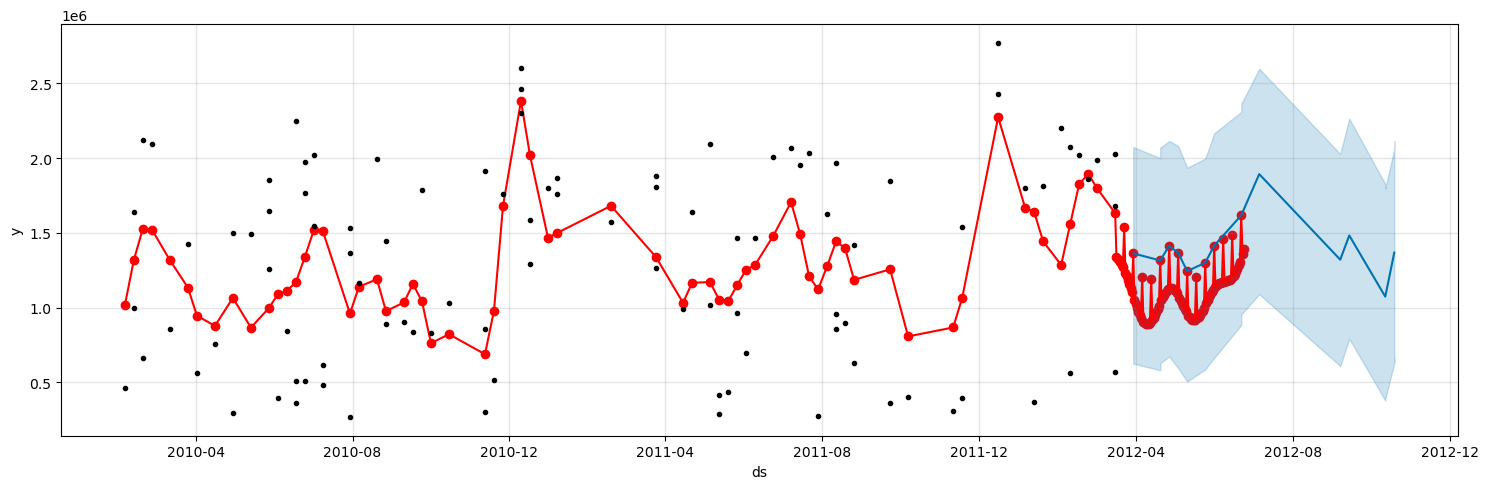

In [298]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(prevision['ds'], prevision['yhat'], color='r')
ax.plot(prevision['ds'], prevision['yhat'], color='r')
fig = modl.plot(preds, ax=ax)

On observe quand même une certaine saisonnalité pour les ventes avec un pic pour noel.

Le modèle n'est pas bon car il y a eu une augmentation des ventes sans que le modèle le prenne en compte, ce qui donne des prédictions inférieures aux valeurs réelles

Observons les tendances en fonction de différentes périodes: 

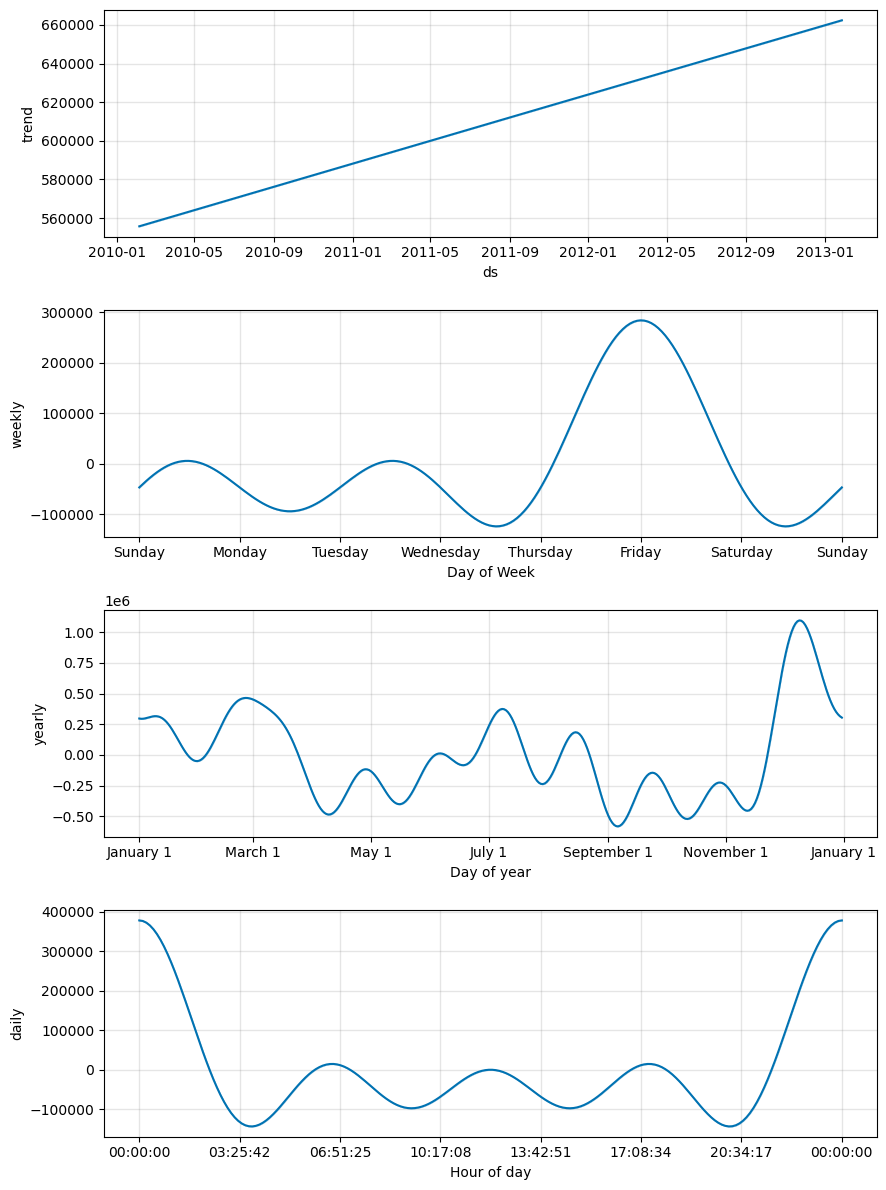

In [282]:
fig2 = m.plot_components(forecast)

Nous allons tester avec tout le dataset pour voir si on peut augmenter les valeurs prédictions temporelles.

In [300]:
ts = df.copy()
ts = ts.sort_values(by='Date')

X = df[['CPI','Temperature', 'Unemployment', 'Fuel_Price', 'Holiday_Flag', 'Store']]
y = df['Weekly_Sales']
       
X_train, X_test, y_train, y_test = X[:100], X[100:], y [:100], y[100:]

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [302]:
regressor=Lasso(alpha=600, max_iter=10000)

regressor.fit(X_train, y_train)

Lasso(alpha=600, max_iter=10000)

In [303]:
y_pred_train = regressor.predict(X_train)
y_pred_test = regressor.predict(X_test)

print (f'R2-score sur le Train: {r2_score(y_train, y_pred_train)}')
print (f'R2-score sur le Test : {r2_score(y_test, y_pred_test)}')
print (f'Cross_Val_Score MEAN sur le Train : {cross_val_score(regressor, X_train, y_train, cv=10).mean()}')
print (f'Cross_Val_Score Std sur le Test : {cross_val_score(regressor, X_train, y_train, cv=10).std()}')

R2-score sur le Train: 0.9558562043427189
R2-score sur le Test : 0.9811461557013939
Cross_Val_Score MEAN sur le Train : 0.9133253899813856
Cross_Val_Score Std sur le Test : 0.04924404232788381


Il y a une légère amélioration des resultats sur le test mais nous n'avons pas assez de ligne pour dire que cela est significatif.